In this script, we demonstrate an example of what happens when we do not include a necessary transformation in TFP.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors

In [14]:
alpha_prior, beta_prior = 4, 3
prior_dist = tfd.Beta(alpha_prior, beta_prior)

conditioned_log_prob = lambda z: prior_dist.log_prob(z)
# set seed
tf.random.set_seed(20)

surrogate_posterior = tfd.Normal(
    loc = tf.Variable(0.5),
    scale = tf.Variable(0.25)
)

surr_0 = tfd.Normal(
    loc = tf.Variable(0.5),
    scale = tf.Variable(0.25)
)

losses_0 = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior = surr_0,
    optimizer = tf.optimizers.Adam(learning_rate=0.05),
    num_steps = 10,
    sample_size = 100
)

losses = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior = surrogate_posterior,
    optimizer = tf.optimizers.Adam(learning_rate=0.05),
    num_steps = 50,
    sample_size = 100
)
surr_2 = tfd.Normal(
    loc = tf.Variable(0.5),
    scale = tf.Variable(0.25)
)

losses_2 = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior = surr_2,
    optimizer = tf.optimizers.Adam(learning_rate=0.05),
    num_steps = 20_000,
    sample_size = 100
)

surr_4 = tfd.Normal(
    loc = tf.Variable(0.5),
    scale = tf.Variable(0.25)
)

losses_4 = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior = surr_4,
    optimizer = tf.optimizers.Adam(learning_rate=0.05),
    num_steps = 100_000,
    sample_size = 100
)


nan
nan
nan


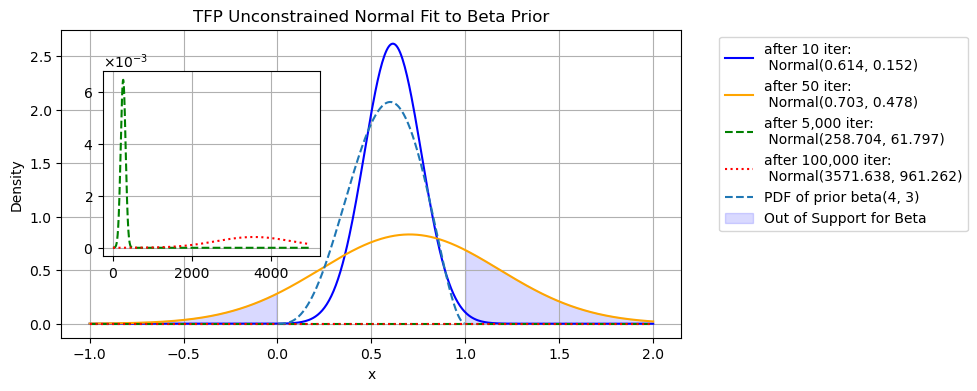

Fitted mean from 10 iter: 0.614, scale: 0.152
Fitted mean from 50 iter: 0.703, scale: 0.478
Fitted mean from 5000 iter: 258.704, scale: 61.797
Fitted mean from 100,000 iter: 3571.638, scale: 961.262
Mass outside support (100000 iter): 0.3378
Mass under 10 iter curve: 1.0000
Mass under 50 iter curve: 0.9965
Mass under 5000 iter curve: 0.0000
Mass under 100000 iter curve: 0.0000


In [22]:

from bakeoff.elbo_computations import _elbo, construct_model
fitted_mean = surrogate_posterior.loc.numpy()
fitted_scale = surrogate_posterior.scale.numpy()
fitted_mean2 = surr_2.loc.numpy()
fitted_scale2 = surr_2.scale.numpy()
fitted_mean0 = surr_0.loc.numpy()
fitted_scale0 = surr_0.scale.numpy()

fitted_mean4 = surr_4.loc.numpy()
fitted_scale4 = surr_4.scale.numpy()
x = np.linspace(-1, 2, 500)
pdf_fitted = tfd.Normal(fitted_mean, fitted_scale).prob(x)
pdf_fitted2 = tfd.Normal(fitted_mean2, fitted_scale2).prob(x)
pdf_fitted0 = tfd.Normal(fitted_mean0, fitted_scale0).prob(x)
pdf_fitted4 = tfd.Normal(fitted_mean4, fitted_scale4).prob(x)
pdf_prior = prior_dist.prob(x)

####
# use numpyro to compute the elbo values to compare with
prior = construct_model('beta', 'z', (alpha_prior, beta_prior))
fitted_guide_0 = construct_model('gaussian', 'z', (fitted_mean0, fitted_scale0))
fitted_guide = construct_model('gaussian', 'z', (fitted_mean, fitted_scale))
fitted_guide2 = construct_model('gaussian', 'z', (fitted_mean2, fitted_scale2))

elbo0 = _elbo(prior, fitted_guide_0, None)
elbo = _elbo(prior, fitted_guide, None)
elbo2 = _elbo(prior, fitted_guide2, None)
####

# plt.figure(figsize=(8, 4))
# plt.plot(x, pdf_fitted0 , label=f'after 10 iter:\n Normal({fitted_mean0:.3f}, {fitted_scale0:.3f})')#, elbo={elbo0:.3f}')
# plt.plot(x, pdf_fitted, label=f'after 50 iter:\n Normal({fitted_mean:.3f}, {fitted_scale:.3f})')#, elbo={elbo:.3f}')
# plt.plot(x, pdf_fitted2 , label=f'after 5,000 iter:\n Normal({fitted_mean2:.3f}, {fitted_scale2:.3f})', ls='-')#, elbo={elbo2:.3f}')
# plt.plot(x, pdf_fitted4 , label=f'after 100,000 iter:\n Normal({fitted_mean4:.3f}, {fitted_scale4:.3f})', ls=':')
# plt.plot(x, pdf_prior, '--', label=f'PDF of prior beta({alpha_prior}, {beta_prior})')  # Normalize only on support
# plt.fill_between(x, 0, pdf_fitted , where=(x < 0) | (x > 1), color='blue', alpha=0.15, label='Out of Support for Beta')
# plt.title('TFP Unconstrained Normal Fit to Beta Prior')
# plt.xlabel('x')
# plt.ylabel('Density')
# # make legend outside the axes on the right
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(8, 4))

# ---- main plot
ax.plot(x, pdf_fitted0,
        label=f'after 10 iter:\n Normal({fitted_mean0:.3f}, {fitted_scale0:.3f})',
        color='blue')
ax.plot(x, pdf_fitted,
        label=f'after 50 iter:\n Normal({fitted_mean:.3f}, {fitted_scale:.3f})',
        color='orange')
ax.plot(x, pdf_fitted2,
        label=f'after 5,000 iter:\n Normal({fitted_mean2:.3f}, {fitted_scale2:.3f})',
        ls='--', color='green')
ax.plot(x, pdf_fitted4,
        label=f'after 100,000 iter:\n Normal({fitted_mean4:.3f}, {fitted_scale4:.3f})',
        ls=':', color='red')
ax.plot(x, pdf_prior, '--',
        label=f'PDF of prior beta({alpha_prior}, {beta_prior})')

ax.fill_between(
    x, 0, pdf_fitted,
    where=(x < 0) | (x > 1),
    color='blue', alpha=0.15,
    label='Out of Support for Beta'
)

ax.set_title('TFP Unconstrained Normal Fit to Beta Prior')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ---- inset axes (upper left)
axins = inset_axes(
    ax,
    width="35%",   # relative to parent
    height="60%",
    loc="upper left",
    borderpad=3.0
)

# same plots in inset
inset_x = np.linspace(-1, 5000, 2000)
# axins.plot(x, pdf_fitted0, color='blue')
# axins.plot(x, pdf_fitted, color='orange')
axins.plot(inset_x, tfd.Normal(fitted_mean2, fitted_scale2).prob(inset_x), color='green', ls='--')
axins.plot(inset_x, tfd.Normal(fitted_mean4, fitted_scale4).prob(inset_x), color='red', ls=':')
# axins.plot(inset_x, pdf_prior, '--')

# zoom region
# axins.set_xlim(-0.5, 0.0)
# axins.set_ylim(0.0, 1.5e-6)
axins.grid(True)

from matplotlib.ticker import ScalarFormatter

# scientific notation for inset y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))  # always use scientific notation

axins.yaxis.set_major_formatter(formatter)
# axins.set_yticks([0.0, 5e-5, 1e-4, 1.5e-4, 2e-4])
# axins.tick_params(labelsize=8)
# axins.yaxis.get_offset_text().set_size(8)

# from matplotlib.patches import Rectangle

# # zoom region (must match inset limits)
# x0, x1 = -0.5, 0.0
# y0, y1 = 0.0, 2e-4

# zoom_rect = Rectangle(
#     (x0, y0),
#     x1 - x0,
#     y1 - y0,
#     facecolor='gold',
#     edgecolor='black',
#     alpha=0.2,
#     linewidth=1.0,
#     zorder=0  # keep behind curves
# )

# ax.add_patch(zoom_rect)

plt.show()


# Step 6: Quantify mass outside support
from scipy.stats import norm as spnorm
mass_outside = spnorm.cdf(0, fitted_mean, fitted_scale) + (1 - spnorm.cdf(1, fitted_mean, fitted_scale))
print(f"Fitted mean from 10 iter: {fitted_mean0:.3f}, scale: {fitted_scale0:.3f}")
print(f"Fitted mean from 50 iter: {fitted_mean:.3f}, scale: {fitted_scale:.3f}")
print(f"Fitted mean from 5000 iter: {fitted_mean2:.3f}, scale: {fitted_scale2:.3f}")
print(f"Fitted mean from 100,000 iter: {fitted_mean4:.3f}, scale: {fitted_scale4:.3f}")

# verify each one integrates to one
print(f"Mass outside support (100000 iter): {mass_outside:.4f}")
print(f"Mass under 10 iter curve: {np.trapezoid(pdf_fitted0, x):.4f}")
print(f"Mass under 50 iter curve: {np.trapezoid(pdf_fitted, x):.4f}")
print(f"Mass under 5000 iter curve: {np.trapezoid(pdf_fitted2, x):.4f}")
print(f"Mass under 100000 iter curve: {np.trapezoid(pdf_fitted4, x):.4f}")

What happens when we tell TFP to use a transformation?

In [4]:
transformed_surr =  tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=(),
        bijector=tfb.Sigmoid(),
        initial_parameters={
            'loc': 0.5,
            'scale': 0.25
        }
    )
transformed_surr_0 = tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=(),
        bijector=tfb.Sigmoid(),
        initial_parameters={
            'loc': 0.5,
            'scale': 0.25
        }
    )

transformed_losses_0 = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior = transformed_surr_0,
    optimizer = tf.optimizers.Adam(learning_rate=0.05),
    num_steps = 10,
    sample_size = 100
)


transformed_losses = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior = transformed_surr,
    optimizer = tf.optimizers.Adam(learning_rate=0.05),
    num_steps = 50,
    sample_size = 100
)
transformed_surr_2 = tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=(),
        bijector=tfb.Sigmoid(),
        initial_parameters={
            'loc': 0.5,
            'scale': 0.25
        }
    )

transformed_losses_2 = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior = transformed_surr_2,
    optimizer = tf.optimizers.Adam(learning_rate=0.05),
    num_steps = 500,
    sample_size = 100
)

transformed_surr_4 = tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=(),
        bijector=tfb.Sigmoid(),
        initial_parameters={
            'loc': 0.5,
            'scale': 0.25
        }
    )

transformed_losses_4 = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior = transformed_surr_4,
    optimizer = tf.optimizers.Adam(learning_rate=0.05),
    num_steps = 100000,
    sample_size = 100
)

0.35594735
0.0094445115
0.007504621
0.007580274


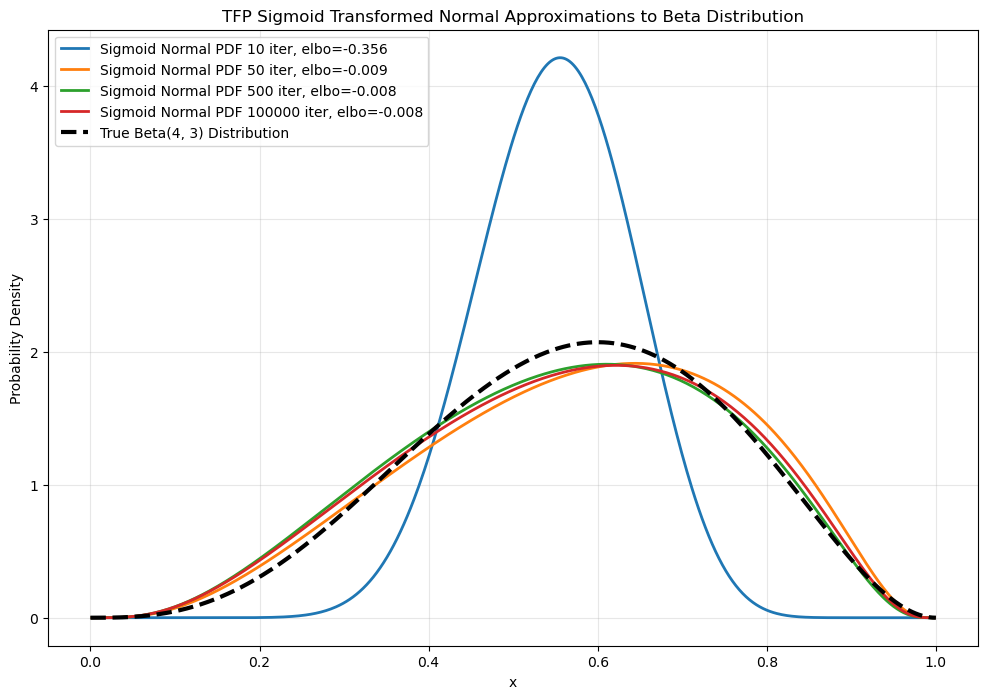

In [5]:
transformed_mean = transformed_surr.distribution.loc.numpy()
transformed_scale = transformed_surr.distribution.scale.numpy()
transformed_mean2 = transformed_surr_2.distribution.loc.numpy()
transformed_scale2 = transformed_surr_2.distribution.scale.numpy()
transformed_mean0 = transformed_surr_0.distribution.loc.numpy()
transformed_scale0 = transformed_surr_0.distribution.scale.numpy()

transformed_mean4 = transformed_surr_4.distribution.loc.numpy()
transformed_scale4 = transformed_surr_4.distribution.scale.numpy()
x = np.linspace(0, 1, 500)  # Changed to [0,1] since we're plotting sigmoid-transformed distributions

# Calculate the actual sigmoid-transformed PDFs by sampling and using the bijector
transf_pdf_fitted = transformed_surr.prob(x)
transf_pdf_fitted2 = transformed_surr_2.prob(x)
transf_pdf_fitted0 = transformed_surr_0.prob(x)
transf_pdf_fitted4 = transformed_surr_4.prob(x)
pdf_prior = prior_dist.prob(x)

####
# use numpyro to compute the elbo values to compare with
prior = construct_model('beta', 'z', (alpha_prior, beta_prior))
transf_fitted_guide_0 = construct_model('sigmoidnormal', 'z', (transformed_mean0, transformed_scale0))
transf_fitted_guide = construct_model('sigmoidnormal', 'z', (transformed_mean, transformed_scale))
transf_fitted_guide2 = construct_model('sigmoidnormal', 'z', (transformed_mean2, transformed_scale2))
transf_fitted_guide4 = construct_model('sigmoidnormal', 'z', (transformed_mean4, transformed_scale4))

transf_elbo0 = _elbo(prior, transf_fitted_guide_0, None)
transf_elbo = _elbo(prior, transf_fitted_guide, None)
transf_elbo2 = _elbo(prior, transf_fitted_guide2, None)
transf_elbo4 = _elbo(prior, transf_fitted_guide4, None)
####

plt.figure(figsize=(12, 8))

# Plot with proper probability densities
plt.plot(x, transf_pdf_fitted0.numpy(), label=f'Sigmoid Normal PDF 10 iter, elbo={transf_elbo0:.3f}', linewidth=2)
plt.plot(x, transf_pdf_fitted.numpy(), label=f'Sigmoid Normal PDF 50 iter, elbo={transf_elbo:.3f}', linewidth=2)
plt.plot(x, transf_pdf_fitted2.numpy(), label=f'Sigmoid Normal PDF 500 iter, elbo={transf_elbo2:.3f}', linewidth=2)
plt.plot(x, transf_pdf_fitted4.numpy(), label=f'Sigmoid Normal PDF 100000 iter, elbo={transf_elbo4:.3f}', linewidth=2)

# Plot the true Beta distribution we're trying to approximate
true_distribution = prior_dist  
plt.plot(x, true_distribution.prob(x).numpy(), '--', label=f'True Beta({alpha_prior}, {beta_prior}) Distribution', linewidth=3, color='black')

plt.title('TFP Sigmoid Transformed Normal Approximations to Beta Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


nan
nan
nan


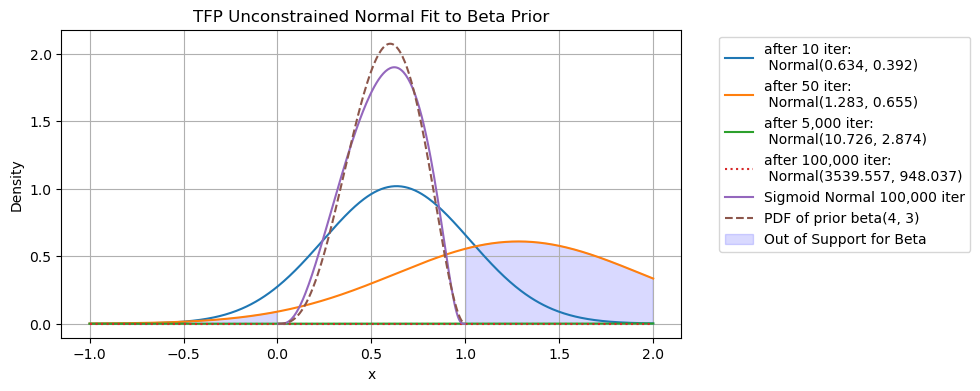

Fitted mean from 10 iter: 0.634, scale: 0.392
Fitted mean from 50 iter: 1.283, scale: 0.655
Fitted mean from 5000 iter: 10.726, scale: 2.874
Fitted mean from 100,000 iter: 3539.557, scale: 948.037
Mass outside support (100000 iter): 0.6922
Mass under 10 iter curve: 0.9997
Mass under 50 iter curve: 0.8630
Mass under 5000 iter curve: 0.0012
Mass under 100000 iter curve: 0.0000


In [6]:
fitted_mean = surrogate_posterior.loc.numpy()
fitted_scale = surrogate_posterior.scale.numpy()
fitted_mean2 = surr_2.loc.numpy()
fitted_scale2 = surr_2.scale.numpy()
fitted_mean0 = surr_0.loc.numpy()
fitted_scale0 = surr_0.scale.numpy()

fitted_mean4 = surr_4.loc.numpy()
fitted_scale4 = surr_4.scale.numpy()
x = np.linspace(-1, 2, 500)
pdf_fitted = tfd.Normal(fitted_mean, fitted_scale).prob(x)
pdf_fitted2 = tfd.Normal(fitted_mean2, fitted_scale2).prob(x)
pdf_fitted0 = tfd.Normal(fitted_mean0, fitted_scale0).prob(x)
pdf_fitted4 = tfd.Normal(fitted_mean4, fitted_scale4).prob(x)
pdf_prior = prior_dist.prob(x)

####
# use numpyro to compute the elbo values to compare with
prior = construct_model('beta', 'z', (alpha_prior, beta_prior))
fitted_guide_0 = construct_model('gaussian', 'z', (fitted_mean0, fitted_scale0))
fitted_guide = construct_model('gaussian', 'z', (fitted_mean, fitted_scale))
fitted_guide2 = construct_model('gaussian', 'z', (fitted_mean2, fitted_scale2))

elbo0 = _elbo(prior, fitted_guide_0, None)
elbo = _elbo(prior, fitted_guide, None)
elbo2 = _elbo(prior, fitted_guide2, None)
####

plt.figure(figsize=(8, 4))
plt.plot(x, pdf_fitted0 , label=f'after 10 iter:\n Normal({fitted_mean0:.3f}, {fitted_scale0:.3f})')#, elbo={elbo0:.3f}')
plt.plot(x, pdf_fitted, label=f'after 50 iter:\n Normal({fitted_mean:.3f}, {fitted_scale:.3f})')#, elbo={elbo:.3f}')
plt.plot(x, pdf_fitted2 , label=f'after 5,000 iter:\n Normal({fitted_mean2:.3f}, {fitted_scale2:.3f})', ls='-')#, elbo={elbo2:.3f}')
plt.plot(x, pdf_fitted4 , label=f'after 100,000 iter:\n Normal({fitted_mean4:.3f}, {fitted_scale4:.3f})', ls=':')
plt.plot(x, transformed_surr_4.prob(x), label='Sigmoid Normal 100,000 iter')
plt.plot(x, pdf_prior, '--', label=f'PDF of prior beta({alpha_prior}, {beta_prior})')  # Normalize only on support
plt.fill_between(x, 0, pdf_fitted , where=(x < 0) | (x > 1), color='blue', alpha=0.15, label='Out of Support for Beta')
plt.title('TFP Unconstrained Normal Fit to Beta Prior')
plt.xlabel('x')
plt.ylabel('Density')
# make legend outside the axes on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Step 6: Quantify mass outside support
from scipy.stats import norm as spnorm
mass_outside = spnorm.cdf(0, fitted_mean, fitted_scale) + (1 - spnorm.cdf(1, fitted_mean, fitted_scale))
print(f"Fitted mean from 10 iter: {fitted_mean0:.3f}, scale: {fitted_scale0:.3f}")
print(f"Fitted mean from 50 iter: {fitted_mean:.3f}, scale: {fitted_scale:.3f}")
print(f"Fitted mean from 5000 iter: {fitted_mean2:.3f}, scale: {fitted_scale2:.3f}")
print(f"Fitted mean from 100,000 iter: {fitted_mean4:.3f}, scale: {fitted_scale4:.3f}")

# verify each one integrates to one
print(f"Mass outside support (100000 iter): {mass_outside:.4f}")
print(f"Mass under 10 iter curve: {np.trapezoid(pdf_fitted0, x):.4f}")
print(f"Mass under 50 iter curve: {np.trapezoid(pdf_fitted, x):.4f}")
print(f"Mass under 5000 iter curve: {np.trapezoid(pdf_fitted2, x):.4f}")
print(f"Mass under 100000 iter curve: {np.trapezoid(pdf_fitted4, x):.4f}")